In [191]:
import pandas as pd
import random
from datetime import datetime, timedelta
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt

## На платформе Kaggle или на Github найдите достаточно большой датасет с логами пользования сервисов (просмотры Youtube или стриминговых сервисов, такси/каршеринг или что угодно, где есть много юзеров и история их взаимодействия с каким-нибудь сервисом). В случае, если такого датасета нет - сгенерируйте самостоятельно (например, как на лекции было показано распределение по просмотру в Кион).

# Подготовка данных

Набор данных включает в себя такую ​​информацию, как 

* тип подписки пользователя (Basic, Standard или Premium)
* ежемесячный доход, полученный от его подписки
* дата присоединения к Netflix (Join Date)
* дата последнего платежа (Last Payment Date)
* страна, в которой он находится
* Возраст
* Пол
* тип устройства (например, Smart TV, мобильный телефон, настольный компьютер, планшет)
* Продолжительность подписки (я так поняла у всех стандартная 1 месяц)

In [71]:
df = pd.read_csv("/Users/tatianasalamatova/reps/MTS_data_analysis/stats_04/Netflix_Userbase.csv", sep = ",")
df

,User ID,Subscription Type,Monthly Revenue,Join Date,Last Payment Date,Country,Age,Gender,Device,Plan Duration
0,1,Basic,10,15-01-22,10-06-23,United States,28,Male,Smartphone,1 Month
1,2,Premium,15,05-09-21,22-06-23,Canada,35,Female,Tablet,1 Month
2,3,Standard,12,28-02-23,27-06-23,United Kingdom,42,Male,Smart TV,1 Month
3,4,Standard,12,10-07-22,26-06-23,Australia,51,Female,Laptop,1 Month
4,5,Basic,10,01-05-23,28-06-23,Germany,33,Male,Smartphone,1 Month
...,...,...,...,...,...,...,...,...,...,...
2495,2496,Premium,14,25-07-22,12-07-23,Spain,28,Female,Smart TV,1 Month
2496,2497,Basic,15,04-08-22,14-07-23,Spain,33,Female,Smart TV,1 Month
2497,2498,Standard,12,09-08-22,15-07-23,United States,38,Male,Laptop,1 Month
2498,2499,Standard,13,12-08-22,12-07-23,Canada,48,Female,Tablet,1 Month


*Генерирую случайных пользователей, чтобы сделать датасет размером 100к уникальных пользователей*

In [72]:
# Сначала получу уникальные возможные значения в каждом столбце:
Subscription_Type = df['Subscription Type'].unique()
Monthly_Revenue = df['Monthly Revenue'].unique()
Country = df['Country'].unique()
Age_max = max(df['Age'])
Age_min = min(df['Age'])
Device = df['Device'].unique()
max_user_id = max(df['User ID'])

# Join Date - буду генерировать случайно в диапазоне с 21 по 23 год
# Last Payment Date	- буду генерировать случайно в течение 23 года с июня по июль
# Age - буду генерировать случайно от макс до мин
# Gender - очевидно, что случайно
# Plan duration - у всех один = 1 month

Генерирую случайную дату в заданном диапазоне, которая возвращает случайную дату в заданном интервале между двумя датами.

In [73]:
def random_date(start, end):
    return start + timedelta(seconds=random.randint(0, int((end - start).total_seconds())))

Генерирую пользователя:

In [74]:
def generate_user(user_id):
    join_date = random_date(datetime(2021, 1, 1), datetime(2023, 12, 31))  # буду генерировать случайно в диапазоне с 21 по 23 год
    last_payment_date = random_date(datetime(2023, 6, 1), datetime(2023, 7, 31))  # буду генерировать случайно в течение 23 года  с июня по июль
    age = random.randint(Age_min, Age_max)  # буду генерировать случайно от макс до мин
    gender = random.choice(['Male', 'Female'])  # случайный пол
    
    return {
        'User ID': user_id,
        'Subscription Type': random.choice(Subscription_Type),
        'Monthly Revenue': random.choice(Monthly_Revenue),
        'Join Date': join_date.strftime('%d-%m-%y'),
        'Last Payment Date': last_payment_date.strftime('%d-%m-%y'),
        'Country': random.choice(Country),
        'Age': age,
        'Gender': gender,
        'Device': random.choice(Device),
        'Plan Duration': '1 Month'  # У всех один и тот же план
    }

In [75]:
new_users = [generate_user(i) for i in range(max_user_id + 1, max_user_id + 100000)]
new_users_df = pd.DataFrame(new_users)

Присоединяю таблицу к имеющейся:

In [76]:
df_analysis = pd.concat([df, new_users_df], ignore_index=True)
df_analysis.head(10)

,User ID,Subscription Type,Monthly Revenue,Join Date,Last Payment Date,Country,Age,Gender,Device,Plan Duration
0,1,Basic,10,15-01-22,10-06-23,United States,28,Male,Smartphone,1 Month
1,2,Premium,15,05-09-21,22-06-23,Canada,35,Female,Tablet,1 Month
2,3,Standard,12,28-02-23,27-06-23,United Kingdom,42,Male,Smart TV,1 Month
3,4,Standard,12,10-07-22,26-06-23,Australia,51,Female,Laptop,1 Month
4,5,Basic,10,01-05-23,28-06-23,Germany,33,Male,Smartphone,1 Month
5,6,Premium,15,18-03-22,27-06-23,France,29,Female,Smart TV,1 Month
6,7,Standard,12,09-12-21,25-06-23,Brazil,46,Male,Tablet,1 Month
7,8,Basic,10,02-04-23,24-06-23,Mexico,39,Female,Laptop,1 Month
8,9,Standard,12,20-10-22,23-06-23,Spain,37,Male,Smartphone,1 Month
9,10,Premium,15,07-01-23,22-06-23,Italy,44,Female,Smart TV,1 Month


## Разбейте на сегменты вашу аудиторию и примените для нескольких (примерно 3-4 метрики) метрик тесты Стьюдента, Манна-Уитни, Фишера (Фишера для нескольких сегментов). Проинтерпретируйте результаты, сделайте первые выводы.

Сегментирую по типу устройства: ['Smartphone', 'Tablet', 'Smart TV', 'Laptop'], получу 4 группы

Выберу метрики: 

* Monthly Revenue (с какого типа устройства пользователи приносят бОльший доход?)
* Subscription Type (на каком устройстве какой тип подписки?)
* Age (одинаков ли средний возраст для разных устройств?)

**Тест Стьюдента: проверю, есть ли статзначимые различия в средних значениях для каждого сегмента по попарному сравнению каждой из метрик?**

Мне нужно проводить тесты Стьюдента, но чтобы не растить ошибку второго рода (из - за проведения попраных сравнений), выберу 4 сегмента (это аргументация почему я взяла по типу устройства). Тогда вероятность ошибки второго рода = $1 - 0.95^4 = 18.5 \% $. При установленом уровене значимости (α), который обычно равен 0.05

Цель: Проверить, отличаются ли средние значения между двумя группами. У меня всего, получается, 6 попарных сравнений. Буду сравнивать так: 

1) Smartphone vs Tablet
2) Smartphone vs Smart TV
3) Smartphone vs Laptop
4) Tablet vs Smart TV
5) Tablet vs Laptop
6) Smart TV vs Laptop

### Сравнение №1 - для метрики Monthly Revenue (с какого типа устройства пользователи приносят бОльший доход?)

Нулевая гипотеза (H0): Средние значения для метрики, указывающей на доход, который приносят пользователи в двух группах одинаковые.

Альтернативная гипотеза (H1): Средние значения в двух группах различаются.

Если p-value < 0.05 => разница статистически значимая, и нулевая гипотеза отвергается

Если p-value больше или равно 0.05 => не отвергаем нулевую гипотезу

In [99]:
def ttest_check(data1, data2, name1 = 'n', name2 = 'n', type = 'по доходу'):
    t_stat, p_value = ttest_ind(data1, data2)
    if p_value < 0.05:
        print(f"Гипотезу о равенстве средних {type} для {name1} vs {name2} ОТВЕРГАЕМ: T-stat = {t_stat}, P-value = {p_value}")
    else:
        print(f"Гипотезу о равенстве средних {type} для {name1} vs {name2} НЕ ОТВЕРГАЕМ: T-stat = {t_stat}, P-value = {p_value}")

In [100]:
# Сегрегация по типу устройства для MR
smartphone_revenue = df_analysis[df_analysis['Device'] == 'Smartphone']['Monthly Revenue']
tablet_revenue = df_analysis[df_analysis['Device'] == 'Tablet']['Monthly Revenue']
smart_tv_revenue = df_analysis[df_analysis['Device'] == 'Smart TV']['Monthly Revenue']
laptop_revenue = df_analysis[df_analysis['Device'] == 'Laptop']['Monthly Revenue']

# Попарные сравнения:
# Smartphone vs Tablet
ttest_check(smartphone_revenue, tablet_revenue, name1 = 'Smartphone', name2 = 'Tablet', type = 'по доходу')

# Smartphone vs Smart TV
ttest_check(smartphone_revenue, smart_tv_revenue, name1 = 'Smartphone', name2 = 'Smart TV', type = 'по доходу')

# Smartphone vs Laptop
ttest_check(smartphone_revenue, laptop_revenue, name1 = 'Smartphone', name2 = 'Laptop', type = 'по доходу')

# Tablet vs Smart TV
ttest_check(tablet_revenue, smart_tv_revenue, name1 = 'Tablet', name2 = 'Smart TV', type = 'по доходу')

# Tablet vs Laptop
ttest_check(tablet_revenue, laptop_revenue, name1 = 'Tablet', name2 = 'Laptop', type = 'по доходу')

# Smart TV vs Laptop
ttest_check(smart_tv_revenue, laptop_revenue, name1 = 'Smart TV', name2 = 'Laptop', type = 'по доходу')


Гипотезу о равенстве средних по доходу для Smartphone vs Tablet НЕ ОТВЕРГАЕМ: T-stat = -1.2315630431166475, P-value = 0.2181179671441775
Гипотезу о равенстве средних по доходу для Smartphone vs Smart TV НЕ ОТВЕРГАЕМ: T-stat = -1.0876484088592229, P-value = 0.2767554581265842
Гипотезу о равенстве средних по доходу для Smartphone vs Laptop НЕ ОТВЕРГАЕМ: T-stat = -1.7704017615356162, P-value = 0.07666619575476752
Гипотезу о равенстве средних по доходу для Tablet vs Smart TV НЕ ОТВЕРГАЕМ: T-stat = 0.14057702270880984, P-value = 0.8882046522573307
Гипотезу о равенстве средних по доходу для Tablet vs Laptop НЕ ОТВЕРГАЕМ: T-stat = -0.5436485446938459, P-value = 0.5866857160358281
Гипотезу о равенстве средних по доходу для Smart TV vs Laptop НЕ ОТВЕРГАЕМ: T-stat = -0.682221197073875, P-value = 0.49510219727144655


Итак, на основании полученных данных, можно сделать вывод, что нулевая гипотеза ни в одном из случаев не была отвергнута. $=>$ статистически значимых различий в среднем доходе между пользователями смартфонов, планшетов, Smart TV и ноутбуков нет. На основании данных можно заключить, что тип устройства, используемого пользователями, не оказывает существенного влияния на средний доход, который они приносят компании. Это может быть связано с тем, что пользователи всех устройств оформляют схожие подписки, вне зависимости от устройства, которое они используют.

### Сравнение №2 - для метрики Subscription Type (на каком устройстве какой тип подписки?)

Для этого переведу подписки в баллы, чтобы было удобенее сравнивать. Пусть Basic = 1, Standard = 2, Premium = 3

Нулевая гипотеза (H0): Средний балл подписки одинаков для двух типов устройств.

Альтернативная гипотеза (H1): Средний "балл подписки" различается для двух типов устройств.

In [ ]:
# дам каждому типу подписки балл (сделаю доп столбец)
df_analysis['Subscription Score'] = df_analysis['Subscription Type'].map({'Basic': 1, 'Standard': 2, 'Premium': 3})

smartphone_sub = df_analysis[df_analysis['Device'] == 'Smartphone']['Subscription Score']
tablet_sub = df_analysis[df_analysis['Device'] == 'Tablet']['Subscription Score']
smart_tv_sub = df_analysis[df_analysis['Device'] == 'Smart TV']['Subscription Score']
laptop_sub = df_analysis[df_analysis['Device'] == 'Laptop']['Subscription Score']

# Попарные сравнения:
# Smartphone vs Tablet
ttest_check(smartphone_sub, tablet_sub, name1 = 'Smartphone', name2 = 'Tablet', type = 'баллов подписки')

# Smartphone vs Smart TV
ttest_check(smartphone_sub, smart_tv_sub, name1 = 'Smartphone', name2 = 'Smart TV', type = 'баллов подписки')

# Smartphone vs Laptop
ttest_check(smartphone_sub, laptop_sub, name1 = 'Smartphone', name2 = 'Laptop', type = 'баллов подписки')

# Tablet vs Smart TV
ttest_check(tablet_sub, smart_tv_sub, name1 = 'Tablet', name2 = 'Smart TV', type = 'баллов подписки')

# Tablet vs Laptop
ttest_check(tablet_sub, laptop_sub, name1 = 'Tablet', name2 = 'Laptop', type = 'баллов подписки')

# Smart TV vs Laptop
ttest_check(smart_tv_sub, laptop_sub, name1 = 'Smart TV', name2 = 'Laptop', type = 'баллов подписки')


Гипотезу о равенстве средних баллов подписки для Smartphone vs Tablet ОТВЕРГАЕМ: T-stat = -2.196820487347239, P-value = 0.028037700697121824
Гипотезу о равенстве средних баллов подписки для Smartphone vs Smart TV НЕ ОТВЕРГАЕМ: T-stat = -1.1520348628734, P-value = 0.24931211284305752
Гипотезу о равенстве средних баллов подписки для Smartphone vs Laptop НЕ ОТВЕРГАЕМ: T-stat = -0.7402085096483305, P-value = 0.45917688463229644
Гипотезу о равенстве средних баллов подписки для Tablet vs Smart TV НЕ ОТВЕРГАЕМ: T-stat = 1.0355886150383866, P-value = 0.3003989795965851
Гипотезу о равенстве средних баллов подписки для Tablet vs Laptop НЕ ОТВЕРГАЕМ: T-stat = 1.4390985430504715, P-value = 0.15012872236446353
Гипотезу о равенстве средних баллов подписки для Smart TV vs Laptop НЕ ОТВЕРГАЕМ: T-stat = 0.40574118902766004, P-value = 0.6849344800216208


Итак, единственное статистически значимое различие в средних баллах подписки наблюдается между пользователями смартфонов и планшетов. У пользователей смартфонов уровень подписки оказывается ниже, чем у пользователей планшетов, что подтверждается значением T-stat = -2.20 и P-value = 0.028. Для остальных пар устройств различия в средних баллах подписки не достигают статистической значимости на уровне 0.05.

Однако, вероятно, имеет место ошибка II рода, так как различия в подписках наблюдаются, а по уровню дохода значимых различий не выявлено. Это может указывать на наличие корреляции между доходом и уровнем подписки, которую тест Стьюдента для среднего дохода не смог зафиксировать

Пострю boxplot для этого

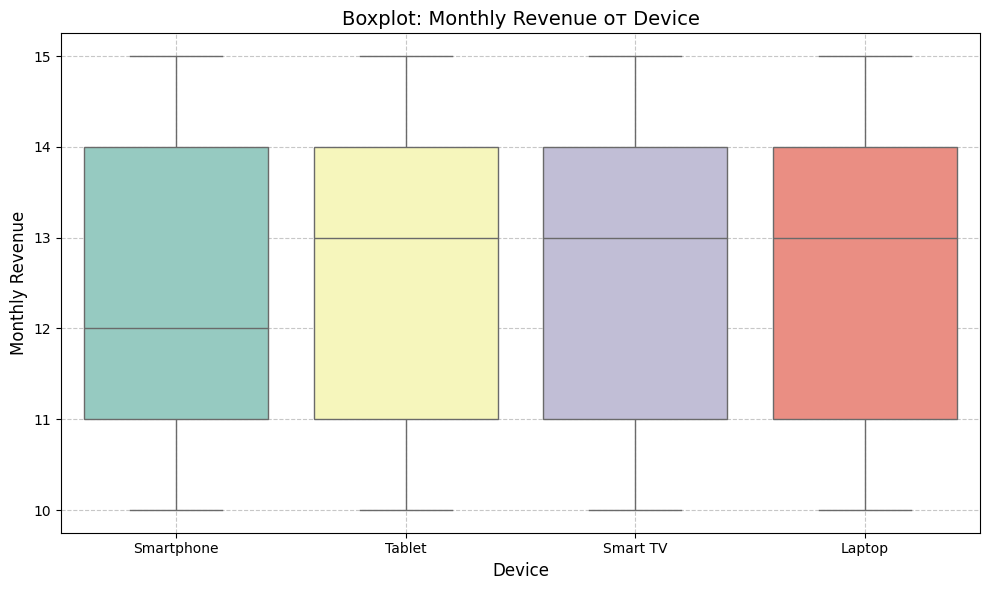

In [96]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_analysis,
    x="Device",
    y="Monthly Revenue",
    hue="Device",
    palette="Set3",
    dodge=False
)
plt.title("Boxplot: Monthly Revenue от Device", fontsize=14)
plt.xlabel("Device", fontsize=12)
plt.ylabel("Monthly Revenue", fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Отсюда видно, что серая горизонтальная линия (которая обозначает медиану дохода) для категории Smartphone находится ниже, чем для других устройств, это указывает на то, что пользователи смартфонов в среднем приносят дохода меньше по сравнению с пользователями других устройств. Что коррелирует с подпиской. Следовательно, мы совершили ошибку II рода в тесте Стьюдента для метрики Monthly Revenue

### Сравнение №3 - для метрики Age (одинаков ли средний возраст пользователей для разных типов устройств?)

Нулевая гипотеза (H0): Средний возраст пользователей для всех типов устройств одинаков

Альтернативная гипотеза (H1): Средний возраст пользователей для разных типов устройств отличается

In [97]:
smartphone_age = df_analysis[df_analysis['Device'] == 'Smartphone']['Age']
tablet_age = df_analysis[df_analysis['Device'] == 'Tablet']['Age']
smart_tv_age = df_analysis[df_analysis['Device'] == 'Smart TV']['Age']
laptop_age = df_analysis[df_analysis['Device'] == 'Laptop']['Age']

# Попарные сравнения:
# Smartphone vs Tablet
ttest_check(smartphone_age, tablet_age, name1 = 'Smartphone', name2 = 'Tablet', type = 'возрастов')

# Smartphone vs Smart TV
ttest_check(smartphone_age, smart_tv_age, name1 = 'Smartphone', name2 = 'Smart TV', type = 'возрастов')

# Smartphone vs Laptop
ttest_check(smartphone_age, laptop_age, name1 = 'Smartphone', name2 = 'Laptop', type = 'возрастов')

# Tablet vs Smart TV
ttest_check(tablet_age, smart_tv_age, name1 = 'Tablet', name2 = 'Smart TV', type = 'возрастов')

# Tablet vs Laptop
ttest_check(tablet_age, laptop_age, name1 = 'Tablet', name2 = 'Laptop', type = 'возрастов')

# Smart TV vs Laptop
ttest_check(smart_tv_age, laptop_age, name1 = 'Smart TV', name2 = 'Laptop', type = 'возрастов')

Гипотезу о равенстве средних возрастов для Smartphone vs Tablet НЕ ОТВЕРГАЕМ: T-stat = -1.2022511945943066, P-value = 0.22927173810025514
Гипотезу о равенстве средних возрастов для Smartphone vs Smart TV ОТВЕРГАЕМ: T-stat = -2.014356654869004, P-value = 0.043977307374081016
Гипотезу о равенстве средних возрастов для Smartphone vs Laptop ОТВЕРГАЕМ: T-stat = -2.5415779545145596, P-value = 0.011038260853527871
Гипотезу о равенстве средних возрастов для Tablet vs Smart TV НЕ ОТВЕРГАЕМ: T-stat = -0.8152174511050093, P-value = 0.41495162927937723
Гипотезу о равенстве средних возрастов для Tablet vs Laptop НЕ ОТВЕРГАЕМ: T-stat = -1.3476639297922544, P-value = 0.17777246583329878
Гипотезу о равенстве средних возрастов для Smart TV vs Laptop НЕ ОТВЕРГАЕМ: T-stat = -0.5346466426217451, P-value = 0.59289655918294


Итак, результаты анализа показывают, что средний возраст пользователей отличается в зависимости от используемого устройства. Статистически значимые различия выявлены между пользователями смартфонов и Smart TV (T-stat = -2.01), а также между пользователями смартфонов и ноутбуков (T-stat = -2.54). В обоих случаях пользователи смартфонов оказались младше, чем пользователи Smart TV и ноутбуков. Для остальных пар устройств различий в среднем возрасте не обнаружено, что говорит о том, что эти группы пользователей имеют схожие возрастные характеристики. Данные выводы могут свидетельствовать о том, что смартфоны чаще используются молодыми людьми, тогда как Smart TV и ноутбуки более популярны среди старших возрастных групп. 

**Тест Манна-Уитни: проверю, есть ли статзначимые различия в распределениях выборок для каждого сегмента по попарному сравнению каждой из метрик?**

H_0: Распределения для двух групп одинаковы.

H_1: Распределения для двух групп различаются (распределения одинаковые, но одно распределение смещено относительно другого).


### Сравнение №1 - для метрики Monthly Revenue (для какого типа устройства какое распределение по доходу?)

In [102]:
def mannwhitneyu_check(data1, data2, name1 = 'n', name2 = 'n', type = 'по доходу'):
    t_stat, p_value = mannwhitneyu(data1, data2)
    if p_value < 0.05:
        print(f"Гипотезу о равенстве распределений {type} для {name1} vs {name2} ОТВЕРГАЕМ: T-stat = {t_stat}, P-value = {p_value}")
    else:
        print(f"Гипотезу о равенстве распределений {type} для {name1} vs {name2} НЕ ОТВЕРГАЕМ: T-stat = {t_stat}, P-value = {p_value}")

In [105]:
# Попарные сравнения:
# Smartphone vs Tablet
mannwhitneyu_check(smartphone_revenue, tablet_revenue, name1 = 'Smartphone', name2 = 'Tablet', type = 'по доходу')

# Smartphone vs Smart TV
mannwhitneyu_check(smartphone_revenue, smart_tv_revenue, name1 = 'Smartphone', name2 = 'Smart TV', type = 'по доходу')

# Smartphone vs Laptop
mannwhitneyu_check(smartphone_revenue, laptop_revenue, name1 = 'Smartphone', name2 = 'Laptop', type = 'по доходу')

# Tablet vs Smart TV
mannwhitneyu_check(tablet_revenue, smart_tv_revenue, name1 = 'Tablet', name2 = 'Smart TV', type = 'по доходу')

# Tablet vs Laptop
mannwhitneyu_check(tablet_revenue, laptop_revenue, name1 = 'Tablet', name2 = 'Laptop', type = 'по доходу')

# Smart TV vs Laptop
mannwhitneyu_check(smart_tv_revenue, laptop_revenue, name1 = 'Smart TV', name2 = 'Laptop', type = 'по доходу')


Гипотезу о равенстве распределений по доходу для Smartphone vs Tablet НЕ ОТВЕРГАЕМ: T-stat = 330646778.5, P-value = 0.21745429223645973
Гипотезу о равенстве распределений по доходу для Smartphone vs Smart TV НЕ ОТВЕРГАЕМ: T-stat = 327590796.0, P-value = 0.2765412042428872
Гипотезу о равенстве распределений по доходу для Smartphone vs Laptop НЕ ОТВЕРГАЕМ: T-stat = 323698475.0, P-value = 0.07684760237241087
Гипотезу о равенстве распределений по доходу для Tablet vs Smart TV НЕ ОТВЕРГАЕМ: T-stat = 330226480.5, P-value = 0.8878089305773061
Гипотезу о равенстве распределений по доходу для Tablet vs Laptop НЕ ОТВЕРГАЕМ: T-stat = 326305853.0, P-value = 0.5854630242176775
Гипотезу о равенстве распределений по доходу для Smart TV vs Laptop НЕ ОТВЕРГАЕМ: T-stat = 322831017.0, P-value = 0.49472067668183695


### Сравнение №2 - для метрики Subscription Type

In [107]:
# Попарные сравнения:
# Smartphone vs Tablet
mannwhitneyu_check(smartphone_sub, tablet_sub, name1 = 'Smartphone', name2 = 'Tablet', type = 'баллов подписки')

# Smartphone vs Smart TV
mannwhitneyu_check(smartphone_sub, smart_tv_sub, name1 = 'Smartphone', name2 = 'Smart TV', type = 'баллов подписки')

# Smartphone vs Laptop
mannwhitneyu_check(smartphone_sub, laptop_sub, name1 = 'Smartphone', name2 = 'Laptop', type = 'баллов подписки')

# Tablet vs Smart TV
mannwhitneyu_check(tablet_sub, smart_tv_sub, name1 = 'Tablet', name2 = 'Smart TV', type = 'баллов подписки')

# Tablet vs Laptop
mannwhitneyu_check(tablet_sub, laptop_sub, name1 = 'Tablet', name2 = 'Laptop', type = 'баллов подписки')

# Smart TV vs Laptop
mannwhitneyu_check(smart_tv_sub, laptop_sub, name1 = 'Smart TV', name2 = 'Laptop', type = 'баллов подписки')


Гипотезу о равенстве распределений баллов подписки для Smartphone vs Tablet ОТВЕРГАЕМ: T-stat = 329200739.0, P-value = 0.028045846823114094
Гипотезу о равенстве распределений баллов подписки для Smartphone vs Smart TV НЕ ОТВЕРГАЕМ: T-stat = 327570781.0, P-value = 0.24988371662105446
Гипотезу о равенстве распределений баллов подписки для Smartphone vs Laptop НЕ ОТВЕРГАЕМ: T-stat = 325451450.0, P-value = 0.46188508871103784
Гипотезу о равенстве распределений баллов подписки для Tablet vs Smart TV НЕ ОТВЕРГАЕМ: T-stat = 331629404.0, P-value = 0.3017339686593714
Гипотезу о равенстве распределений баллов подписки для Tablet vs Laptop НЕ ОТВЕРГАЕМ: T-stat = 329464627.0, P-value = 0.15119496714620922
Гипотезу о равенстве распределений баллов подписки для Smart TV vs Laptop НЕ ОТВЕРГАЕМ: T-stat = 324581756.0, P-value = 0.6847722374566488


### Сравнение №3 - для метрики Age (одинаков ли средний возраст пользователей для разных типов устройств?)

In [109]:
# Попарные сравнения:
# Smartphone vs Tablet
mannwhitneyu_check(smartphone_age, tablet_age, name1 = 'Smartphone', name2 = 'Tablet', type = 'возрастов')

# Smartphone vs Smart TV
mannwhitneyu_check(smartphone_age, smart_tv_age, name1 = 'Smartphone', name2 = 'Smart TV', type = 'возрастов')

# Smartphone vs Laptop
mannwhitneyu_check(smartphone_age, laptop_age, name1 = 'Smartphone', name2 = 'Laptop', type = 'возрастов')

# Tablet vs Smart TV
mannwhitneyu_check(tablet_age, smart_tv_age, name1 = 'Tablet', name2 = 'Smart TV', type = 'возрастов')

# Tablet vs Laptop
mannwhitneyu_check(tablet_age, laptop_age, name1 = 'Tablet', name2 = 'Laptop', type = 'возрастов')

# Smart TV vs Laptop
mannwhitneyu_check(smart_tv_age, laptop_age, name1 = 'Smart TV', name2 = 'Laptop', type = 'возрастов')

Гипотезу о равенстве распределений возрастов для Smartphone vs Tablet НЕ ОТВЕРГАЕМ: T-stat = 330670516.5, P-value = 0.22900393901618954
Гипотезу о равенстве распределений возрастов для Smartphone vs Smart TV ОТВЕРГАЕМ: T-stat = 326002401.5, P-value = 0.04332443113626383
Гипотезу о равенстве распределений возрастов для Smartphone vs Laptop ОТВЕРГАЕМ: T-stat = 322395630.5, P-value = 0.01149062898837868
Гипотезу о равенстве распределений возрастов для Tablet vs Smart TV НЕ ОТВЕРГАЕМ: T-stat = 328627747.0, P-value = 0.4164889066337196
Гипотезу о равенстве распределений возрастов для Tablet vs Laptop НЕ ОТВЕРГАЕМ: T-stat = 324960758.0, P-value = 0.1789379419403413
Гипотезу о равенстве распределений возрастов для Smart TV vs Laptop НЕ ОТВЕРГАЕМ: T-stat = 323050939.0, P-value = 0.5884965626112851


## Результаты теста Манна-Уитни полностью коррелируют с результатами теста Стьюдента $=>$ выводы остаются аналогичными

# Тест Фишера для нескольких сегментов

Для теста Фишера для нескольких сегментов нужно сделать таблицы сопряженности (будет новая таблица для каждой метрики)

Поскольку Monthly Revenue и Age - числовые переменные, сделаю их категориальными:

In [132]:
# Доход
df_analysis['Revenue Group'] = pd.cut(df_analysis['Monthly Revenue'], bins=[9, 12, 14, 15], labels=['Low', 'Medium', 'High'])
contingency_table_revenue = pd.crosstab(df_analysis['Device'], df_analysis['Revenue Group'])

# Возраст
def age_group(age):
    if age <= 30:
        return '18-30'
    elif age <= 50:
        return '31-50'
    else:
        return '>50'

df_analysis['Age Group'] = df_analysis['Age'].apply(age_group)

contingency_table_age = pd.crosstab(df_analysis['Device'], df_analysis['Age Group'])

# Тип подписки (Score)

contingency_table_subscription_score = pd.crosstab(df_analysis['Device'], df_analysis['Subscription Score'])

In [113]:
contingency_table_revenue

Revenue Group,Low,Medium,High
Device,,,
Laptop,12531,8661,4154
Smart TV,12765,8540,4257
Smartphone,12980,8584,4208
Tablet,12904,8614,4301


In [115]:
contingency_table_age

Age Group,18-30,31-50,>50
Device,,,
Laptop,4731,19620,995
Smart TV,4760,19793,1009
Smartphone,5126,19633,1013
Tablet,4961,19875,983


In [116]:
contingency_table_subscription_score

Subscription Score,1,2,3
Device,,,
Laptop,8582,8230,8534
Smart TV,8553,8429,8580
Smartphone,8675,8609,8488
Tablet,8469,8661,8689


In [112]:
df_analysis

,User ID,Subscription Type,Monthly Revenue,Join Date,Last Payment Date,Country,Age,Gender,Device,Plan Duration,Subscription Score,Revenue Group,Age Group
0,1,Basic,10,15-01-22,10-06-23,United States,28,Male,Smartphone,1 Month,1,Low,18-30
1,2,Premium,15,05-09-21,22-06-23,Canada,35,Female,Tablet,1 Month,3,High,31-50
2,3,Standard,12,28-02-23,27-06-23,United Kingdom,42,Male,Smart TV,1 Month,2,Low,31-50
3,4,Standard,12,10-07-22,26-06-23,Australia,51,Female,Laptop,1 Month,2,Low,>50
4,5,Basic,10,01-05-23,28-06-23,Germany,33,Male,Smartphone,1 Month,1,Low,31-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102494,102495,Standard,14,01-07-22,23-07-23,Canada,48,Female,Smart TV,1 Month,2,Medium,31-50
102495,102496,Premium,12,09-10-23,28-07-23,Germany,37,Male,Smartphone,1 Month,3,Low,31-50
102496,102497,Standard,11,09-04-23,26-07-23,Italy,51,Male,Tablet,1 Month,2,Low,>50
102497,102498,Standard,14,02-07-22,16-06-23,United States,28,Female,Smart TV,1 Month,2,Medium,18-30


In [120]:
def many_fisher(table, metrics = 'уровнем дохода'):
    chi2_stat, p_value, _, _ = chi2_contingency(table)
    if p_value < 0.05:
        print(f"Хотя бы в одном месте в таблице есть статистически значимая зависимость между типом устройства и {metrics}, P-value = {p_value}")
    else:
        print(f"Гипотеза о независимости не отвергается, что означает, что {metrics} не зависит от типа устройства, P-value = {p_value}")

In [183]:
# для дохода
many_fisher(contingency_table_revenue, metrics = 'уровень дохода')

# для типа подписки
many_fisher(contingency_table_subscription_score, metrics = 'типом подписки')

# для возраста
many_fisher(contingency_table_age, metrics = 'возрастной группой')

Гипотеза о независимости не отвергается, что означает, что уровень дохода не зависит от типа устройства, P-value = 0.28582461438730766
Хотя бы в одном месте в таблице есть статистически значимая зависимость между типом устройства и типом подписки, P-value = 0.04131283392507345
Хотя бы в одном месте в таблице есть статистически значимая зависимость между типом устройства и возрастной группой, P-value = 0.005300471261375393


Результаты теста Фишера также согласуются с попраными тестами Фишера и Манна-Уитни

# Для >=3 сегментов сделайте попарные сравнения через тест Стьюдента и тест Фишера. Проверьте соотносятся ли результаты.

Я так понимаю, просто добавлю здесь сравнение таблиц Фишера 2 на n (кол - во вариантов в метрике) с уже имеющимся тестом Стьюдента. Для удобства перетащу (скопирую) блок кода для Стьюдента сюда еще раз.

Сделаю таблицы сопряженности для всех 6ти пар типов устройств: 
* Smartphone vs Tablet
* Smartphone vs Smart TV
* Smartphone vs Laptop
* Smartphone vs Laptop
* Tablet vs Laptop
* Smart TV vs Laptop

**Попарный тест Фишера по доходу**

In [184]:
def two_fisher(table, dev1 = 'Tab', dev2 = 'Lap', metrics = 'Уровень дохода'):
    chi2_stat, p_value, _, _ = chi2_contingency(table)
    if p_value < 0.05:
        print(f"Есть статистически значимая зависимость между {metrics} от {dev1} и {dev2}, P-value = {p_value:.5f}, χ² = {chi2_stat:.2f}")
    else:
        print(f"Не была обнаружена статистически значимая зависимость между {metrics} и типами устройств {dev1} и {dev2}. P-value = {p_value:.5f}, χ² = {chi2_stat:.2f}.")

In [185]:
devices = ['Smartphone', 'Tablet', 'Smart TV', 'Laptop']
device_pairs = list(combinations(devices, 2))

for device1, device2 in device_pairs:
    cross_df = df_analysis[df_analysis['Device'].isin([device1, device2])]
    contingency_table = pd.crosstab(cross_df['Device'], cross_df['Revenue Group'])
    two_fisher(contingency_table, dev1 = device1, dev2 = device2, metrics = 'уровнем дохода')

Не была обнаружена статистически значимая зависимость между уровнем дохода и типами устройств Smartphone и Tablet. P-value = 0.53550, χ² = 1.25.
Не была обнаружена статистически значимая зависимость между уровнем дохода и типами устройств Smartphone и Smart TV. P-value = 0.51347, χ² = 1.33.
Не была обнаружена статистически значимая зависимость между уровнем дохода и типами устройств Smartphone и Laptop. P-value = 0.08025, χ² = 5.05.
Не была обнаружена статистически значимая зависимость между уровнем дохода и типами устройств Tablet и Smart TV. P-value = 0.99369, χ² = 0.01.
Не была обнаружена статистически значимая зависимость между уровнем дохода и типами устройств Tablet и Laptop. P-value = 0.15098, χ² = 3.78.
Не была обнаружена статистически значимая зависимость между уровнем дохода и типами устройств Smart TV и Laptop. P-value = 0.18631, χ² = 3.36.


**попарый Стьюдент по доходу**

In [186]:
# Попарные сравнения:
# Smartphone vs Tablet
ttest_check(smartphone_revenue, tablet_revenue, name1 = 'Smartphone', name2 = 'Tablet', type = 'по доходу')

# Smartphone vs Smart TV
ttest_check(smartphone_revenue, smart_tv_revenue, name1 = 'Smartphone', name2 = 'Smart TV', type = 'по доходу')

# Smartphone vs Laptop
ttest_check(smartphone_revenue, laptop_revenue, name1 = 'Smartphone', name2 = 'Laptop', type = 'по доходу')

# Tablet vs Smart TV
ttest_check(tablet_revenue, smart_tv_revenue, name1 = 'Tablet', name2 = 'Smart TV', type = 'по доходу')

# Tablet vs Laptop
ttest_check(tablet_revenue, laptop_revenue, name1 = 'Tablet', name2 = 'Laptop', type = 'по доходу')

# Smart TV vs Laptop
ttest_check(smart_tv_revenue, laptop_revenue, name1 = 'Smart TV', name2 = 'Laptop', type = 'по доходу')

Гипотезу о равенстве средних по доходу для Smartphone vs Tablet НЕ ОТВЕРГАЕМ: T-stat = -1.2315630431166475, P-value = 0.2181179671441775
Гипотезу о равенстве средних по доходу для Smartphone vs Smart TV НЕ ОТВЕРГАЕМ: T-stat = -1.0876484088592229, P-value = 0.2767554581265842
Гипотезу о равенстве средних по доходу для Smartphone vs Laptop НЕ ОТВЕРГАЕМ: T-stat = -1.7704017615356162, P-value = 0.07666619575476752
Гипотезу о равенстве средних по доходу для Tablet vs Smart TV НЕ ОТВЕРГАЕМ: T-stat = 0.14057702270880984, P-value = 0.8882046522573307
Гипотезу о равенстве средних по доходу для Tablet vs Laptop НЕ ОТВЕРГАЕМ: T-stat = -0.5436485446938459, P-value = 0.5866857160358281
Гипотезу о равенстве средних по доходу для Smart TV vs Laptop НЕ ОТВЕРГАЕМ: T-stat = -0.682221197073875, P-value = 0.49510219727144655


Итак, в результате сравнения, результаты попарного теста Стьюдента и теста Фишера оказались одинаковыми, что вызывает интерес. На box-графике выше мы явно видели, что средний доход пользователей смартфонов ниже, чем у пользователей других устройств. Обычно тест Фишера, который менее чувствителен к ошибкам второго рода, должен был бы уловить этот эффект. Однако, вероятно, его отсутствие можно объяснить малой дисперсией в данных, так как диапазон значений в столбце "Monthly Revenue" ограничен значениями от 10 до 15, что снижает вероятность выявления статистически значимой зависимости.

**Попарный тест Фишера по подписке**

In [ ]:
for device1, device2 in device_pairs:
    cross_df = df_analysis[df_analysis['Device'].isin([device1, device2])]
    contingency_table = pd.crosstab(cross_df['Device'], cross_df['Subscription Score'])
    two_fisher(contingency_table, dev1 = device1, dev2 = device2, metrics = 'баллами подписки')

Не была обнаружена статистически значимая зависимость между баллами подписки и типами устройств Smartphone и Tablet. P-value = 0.08454, χ² = 4.94.
Не была обнаружена статистически значимая зависимость между баллами подписки и типами устройств Smartphone и Smart TV. P-value = 0.30083, χ² = 2.40.
Не была обнаружена статистически значимая зависимость между баллами подписки и типами устройств Smartphone и Laptop. P-value = 0.06063, χ² = 5.61.
Не была обнаружена статистически значимая зависимость между баллами подписки и типами устройств Tablet и Smart TV. P-value = 0.22689, χ² = 2.97.
Есть статистически значимая зависимость между баллами подписки от Tablet и Laptop, P-value = 0.01247, χ² = 8.77
Не была обнаружена статистически значимая зависимость между баллами подписки и типами устройств Smart TV и Laptop. P-value = 0.44188, χ² = 1.63.


**попарый Стьюдент по подписке**

In [188]:
# Попарные сравнения:
# Smartphone vs Tablet
ttest_check(smartphone_sub, tablet_sub, name1 = 'Smartphone', name2 = 'Tablet', type = 'баллов подписки')

# Smartphone vs Smart TV
ttest_check(smartphone_sub, smart_tv_sub, name1 = 'Smartphone', name2 = 'Smart TV', type = 'баллов подписки')

# Smartphone vs Laptop
ttest_check(smartphone_sub, laptop_sub, name1 = 'Smartphone', name2 = 'Laptop', type = 'баллов подписки')

# Tablet vs Smart TV
ttest_check(tablet_sub, smart_tv_sub, name1 = 'Tablet', name2 = 'Smart TV', type = 'баллов подписки')

# Tablet vs Laptop
ttest_check(tablet_sub, laptop_sub, name1 = 'Tablet', name2 = 'Laptop', type = 'баллов подписки')

# Smart TV vs Laptop
ttest_check(smart_tv_sub, laptop_sub, name1 = 'Smart TV', name2 = 'Laptop', type = 'баллов подписки')

Гипотезу о равенстве средних баллов подписки для Smartphone vs Tablet ОТВЕРГАЕМ: T-stat = -2.196820487347239, P-value = 0.028037700697121824
Гипотезу о равенстве средних баллов подписки для Smartphone vs Smart TV НЕ ОТВЕРГАЕМ: T-stat = -1.1520348628734, P-value = 0.24931211284305752
Гипотезу о равенстве средних баллов подписки для Smartphone vs Laptop НЕ ОТВЕРГАЕМ: T-stat = -0.7402085096483305, P-value = 0.45917688463229644
Гипотезу о равенстве средних баллов подписки для Tablet vs Smart TV НЕ ОТВЕРГАЕМ: T-stat = 1.0355886150383866, P-value = 0.3003989795965851
Гипотезу о равенстве средних баллов подписки для Tablet vs Laptop НЕ ОТВЕРГАЕМ: T-stat = 1.4390985430504715, P-value = 0.15012872236446353
Гипотезу о равенстве средних баллов подписки для Smart TV vs Laptop НЕ ОТВЕРГАЕМ: T-stat = 0.40574118902766004, P-value = 0.6849344800216208


Интересно, что многокомпонентный тест Фишера выявил статистически значимые различия хотя бы в одном месте. Я ожидала, что это будет между Smartphone и Tablet, как в попарном тесте Стьюдента. Однако попарный тест Фишера зафиксировал статистически значимые различия между Tablet и Laptop. Я думаю такие разные результаты могут быть связаны с тем, что тест Стьюдента оценивает различия в средних значениях между двумя группами и чувствителен к выборке с большими дисперсиями. В то время как попарный тест Фишера анализирует статистическую зависимость и может быть менее чувствителен к выбросам и колебаниям в средних значениях, обращая больше внимания на распределение данных и частоты в разных категориях.

Наверное, различия в выборках между Tablet и Laptop — это результат более выраженной дисперсии или другого распределения значений дохода, что не так явно проявляется в среднем значении, но становится заметным при анализе частот, который и используется в тесте Фишера.

**Попарный тест Фишера по возрасту**

In [190]:
for device1, device2 in device_pairs:
    cross_df = df_analysis[df_analysis['Device'].isin([device1, device2])]
    contingency_table = pd.crosstab(cross_df['Device'], cross_df['Age Group'])
    two_fisher(contingency_table, dev1 = device1, dev2 = device2, metrics = 'возрастом')

Не была обнаружена статистически значимая зависимость между возрастом и типами устройств Smartphone и Tablet. P-value = 0.10079, χ² = 4.59.
Есть статистически значимая зависимость между возрастом от Smartphone и Smart TV, P-value = 0.00126, χ² = 13.35
Есть статистически значимая зависимость между возрастом от Smartphone и Laptop, P-value = 0.00198, χ² = 12.45
Не была обнаружена статистически значимая зависимость между возрастом и типами устройств Tablet и Smart TV. P-value = 0.18456, χ² = 3.38.
Не была обнаружена статистически значимая зависимость между возрастом и типами устройств Tablet и Laptop. P-value = 0.24600, χ² = 2.80.
Не была обнаружена статистически значимая зависимость между возрастом и типами устройств Smart TV и Laptop. P-value = 0.98545, χ² = 0.03.


**попарый Стьюдент по возрасту**

In [124]:
# Попарные сравнения:
# Smartphone vs Tablet
ttest_check(smartphone_age, tablet_age, name1 = 'Smartphone', name2 = 'Tablet', type = 'возрастов')

# Smartphone vs Smart TV
ttest_check(smartphone_age, smart_tv_age, name1 = 'Smartphone', name2 = 'Smart TV', type = 'возрастов')

# Smartphone vs Laptop
ttest_check(smartphone_age, laptop_age, name1 = 'Smartphone', name2 = 'Laptop', type = 'возрастов')

# Tablet vs Smart TV
ttest_check(tablet_age, smart_tv_age, name1 = 'Tablet', name2 = 'Smart TV', type = 'возрастов')

# Tablet vs Laptop
ttest_check(tablet_age, laptop_age, name1 = 'Tablet', name2 = 'Laptop', type = 'возрастов')

# Smart TV vs Laptop
ttest_check(smart_tv_age, laptop_age, name1 = 'Smart TV', name2 = 'Laptop', type = 'возрастов')

Гипотезу о равенстве средних возрастов для Smartphone vs Tablet НЕ ОТВЕРГАЕМ: T-stat = -1.2022511945943066, P-value = 0.22927173810025514
Гипотезу о равенстве средних возрастов для Smartphone vs Smart TV ОТВЕРГАЕМ: T-stat = -2.014356654869004, P-value = 0.043977307374081016
Гипотезу о равенстве средних возрастов для Smartphone vs Laptop ОТВЕРГАЕМ: T-stat = -2.5415779545145596, P-value = 0.011038260853527871
Гипотезу о равенстве средних возрастов для Tablet vs Smart TV НЕ ОТВЕРГАЕМ: T-stat = -0.8152174511050093, P-value = 0.41495162927937723
Гипотезу о равенстве средних возрастов для Tablet vs Laptop НЕ ОТВЕРГАЕМ: T-stat = -1.3476639297922544, P-value = 0.17777246583329878
Гипотезу о равенстве средних возрастов для Smart TV vs Laptop НЕ ОТВЕРГАЕМ: T-stat = -0.5346466426217451, P-value = 0.59289655918294


Для анализа влияния возраста, по данным видим, что попарные тесты Стьюдента и тесты Фишера дали одинаковые результаты, несмотря на то, что в этих тестах я использовала разные подходы. В тесте Стьюдента возраст рассматривался как непрерывная переменная, а в тесте Фишера возраст был заранее разделен на 3 категории ("18-30", "31-50", ">50"). Это связано с тем, во - первых, что возраст, разделившись на группы имеет сильные различия между ними. Во - вторых, у нас довольно выраженная разница между возрастными группами, поэтому оба теста (как Стьюдента, так и Фишера) обнаружили те же статистически значимые различия. Например, если различие в среднем возрасте между устройствами (как пример Smartphone и Smart TV) велико, это легко будет обнаружено как при анализе непрерывных данных (Стьюдент), так и при категориальном анализе (Фишер). В - третьих, у нас большой набор данных (в каждой группе довольно большое количество наблюдений).

# Постройте точный и эфронов доверительные интервал для выбранных метрик (revenue, subscription, age). Проверьте соответствуют ли эти доверительные интервалы  результатам теста Стьюдента.

In [193]:
import numpy as np
import pandas as pd
from scipy import stats


# 1. Расчет точных доверительных интервалов
def compute_confidence_intervals(data, confidence=0.95):
    # Для нормального распределения
    mean = np.mean(data)
    std_err = stats.sem(data)  # Стандартная ошибка
    interval = stats.t.interval(confidence, len(data)-1, loc=mean, scale=std_err)
    
    return interval

# Применим для метрик
revenue_ci = compute_confidence_intervals(df_analysis['Monthly Revenue'].dropna())
subscription_ci = compute_confidence_intervals(df_analysis['Subscription Score'].dropna())
age_ci = compute_confidence_intervals(df_analysis['Age'].dropna())

print(f"Доверительный интервал для Monthly Revenue: {revenue_ci}")
print(f"Доверительный интервал для Subscription Score: {subscription_ci}")
print(f"Доверительный интервал для Age: {age_ci}")


Доверительный интервал для Monthly Revenue: (np.float64(12.49221488840069), np.float64(12.51306321187346))
Доверительный интервал для Subscription Score: (np.float64(1.9951097839044725), np.float64(2.0051243647213677))
Доверительный интервал для Age: (np.float64(38.48821179724431), np.float64(38.57997423383892))


Возможные причины и шаги для проверки гипотез:
Различия в доходах могут быть не линейно связаны с подписками.

Уровень подписки может быть более чувствителен к социальным факторам, привычкам или доступности устройства, чем напрямую к доходу. Проверьте, есть ли дополнительные переменные, которые могли бы объяснить выбор подписки.
Низкая мощность теста.

Если выборки небольшие или имеют высокую дисперсию, тест Стьюдента может быть недостаточно мощным. Проверьте размер выборки и распределение доходов для каждой категории устройства.
Проблема с предположением о нормальности.

Тест Стьюдента предполагает нормальное распределение доходов. Если это не так, тест может быть некорректным. Проверьте распределение доходов (например, с помощью гистограммы или теста Шапиро-Уилка).
Используйте непараметрические методы.

Если распределение доходов сильно отклоняется от нормального, попробуйте непараметрические тесты, такие как тест Манна-Уитни или Краскала-Уоллиса.
Корреляция между доходом и типом подписки.

Проверьте корреляцию между доходом и уровнем подписки. Для этого можно использовать коэффициенты корреляции (например, Спирмена, если данные не нормальны).
Проверьте кросс-факторы.

Выполните анализ ANOVA или множественную линейную регрессию, чтобы проверить взаимодействие дохода, устройства и уровня подписки. Это может выявить скрытые связи.

Рекомендуемый подход:
Визуализация данных. Постройте графики:

Boxplot доходов по устройствам.
Scatterplot дохода против уровня подписки с категоризацией по устройствам.
Повторный тест для дохода.

Рассмотрите увеличение размера выборки, если это возможно.
Попробуйте тест Краскала-Уоллиса для всех категорий или Манна-Уитни для парных сравнений.
Множественный анализ.

Проверьте регрессию, где:
Зависимая переменная: уровень подписки.
Независимые переменные: доход, тип устройства.
Учет поправки на множественное тестирование.

Если вы тестировали много гипотез, используйте поправки (например, Бонферрони или Holm) для снижения риска ошибок I и II рода.
Это должно помочь выявить связь между доходами, устройствами и типом подписки, если она действительно существует.